
# Home Loan Default Prediction (Deep Learning – MLP)

**Objective:** Predict whether an applicant will default on a loan using historical data.  
**Dataset:** `/mnt/data/loan_data.csv` (update path if needed)  
**Key Metrics:** Sensitivity (Recall for default=1), ROC AUC.

**Pipeline**
1. Load & preview
2. Null checks
3. Target imbalance check + plot
4. Preprocessing & encoding
5. Train/test split (stratified)
6. Imbalance handling (class-weighted training; optional SMOTE)
7. Scaling
8. Train MLP
9. Evaluate (Sensitivity, ROC AUC, confusion matrix, ROC curve)
10. Optional threshold tuning to increase Sensitivity


In [1]:

# === Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score
)



In [3]:

# === 1) Load dataset ===
DATA_PATH = "loan_data.csv"  
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:

# === 2) Null checks ===
nulls = df.isna().sum().sort_values(ascending=False)
nulls[nulls>0].head(30)


COMMONAREA_MEDI             214865
COMMONAREA_AVG              214865
COMMONAREA_MODE             214865
NONLIVINGAPARTMENTS_MODE    213514
NONLIVINGAPARTMENTS_AVG     213514
NONLIVINGAPARTMENTS_MEDI    213514
FONDKAPREMONT_MODE          210295
LIVINGAPARTMENTS_MODE       210199
LIVINGAPARTMENTS_AVG        210199
LIVINGAPARTMENTS_MEDI       210199
FLOORSMIN_AVG               208642
FLOORSMIN_MODE              208642
FLOORSMIN_MEDI              208642
YEARS_BUILD_MEDI            204488
YEARS_BUILD_MODE            204488
YEARS_BUILD_AVG             204488
OWN_CAR_AGE                 202929
LANDAREA_MEDI               182590
LANDAREA_MODE               182590
LANDAREA_AVG                182590
BASEMENTAREA_MEDI           179943
BASEMENTAREA_AVG            179943
BASEMENTAREA_MODE           179943
EXT_SOURCE_1                173378
NONLIVINGAREA_MODE          169682
NONLIVINGAREA_AVG           169682
NONLIVINGAREA_MEDI          169682
ELEVATORS_MEDI              163891
ELEVATORS_AVG       

Class distribution -> 0 (payer): 282,686 (91.93%), 1 (default): 24,825 (8.07%)


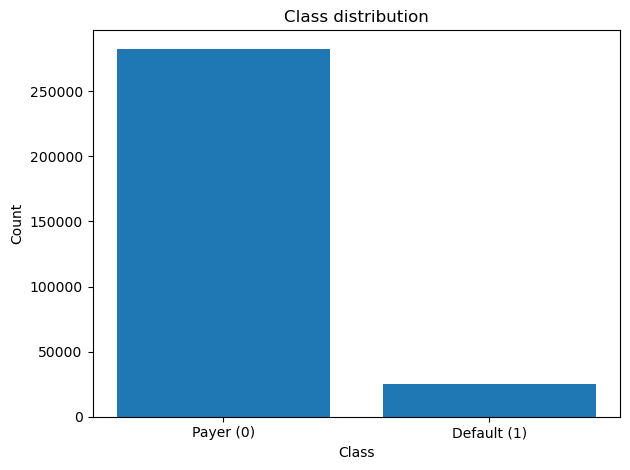

In [5]:

# === 3) Target balance & plot ===
TARGET = "TARGET"  # update if dataset uses a different name
assert TARGET in df.columns, "TARGET column not found. Update the name accordingly."
df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce").fillna(0).astype(int)

counts = df[TARGET].value_counts().sort_index()
pct_default = counts.get(1,0) / len(df) * 100.0
pct_payer   = counts.get(0,0) / len(df) * 100.0
print(f"Class distribution -> 0 (payer): {counts.get(0,0):,} ({pct_payer:.2f}%), "
      f"1 (default): {counts.get(1,0):,} ({pct_default:.2f}%)")

plt.figure()
plt.title("Class distribution")
plt.bar(["Payer (0)", "Default (1)"], [counts.get(0,0), counts.get(1,0)])
plt.xlabel("Class"); plt.ylabel("Count"); plt.tight_layout(); plt.show()


In [6]:

# === 4) Preprocessing & encoding ===
y = df[TARGET].astype(int)
X = df.drop(columns=[TARGET])

# Remove obvious ID-like columns
id_like = [c for c in X.columns if any(k in c.lower() for k in ["id", "sk_", "idx"])]
X = X.drop(columns=id_like, errors="ignore")

cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Impute numerics with median
X_num = X[num_cols].copy()
for c in num_cols:
    if X_num[c].isna().any():
        X_num[c] = X_num[c].fillna(X_num[c].median())

# Impute categoricals with mode & cap high-cardinality (top-50 + 'Other')
X_cat = X[cat_cols].copy()
for c in cat_cols:
    if X_cat[c].isna().any():
        X_cat[c] = X_cat[c].fillna(X_cat[c].mode().iloc[0])
    vc = X_cat[c].value_counts(dropna=False)
    keep = set(vc.head(50).index)
    X_cat[c] = X_cat[c].where(X_cat[c].isin(keep), other="Other")

X_cat_enc = pd.get_dummies(X_cat, drop_first=True, dtype="uint8")
X_enc = pd.concat([X_num, X_cat_enc], axis=1)
X_enc.shape


(307511, 219)

In [7]:

# === 5) Train/test split (stratified) ===
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.2, stratify=y, random_state=42
)



In [8]:

# === 6) Scaling ===
scaler = StandardScaler(with_mean=False)  # safe with sparse-like one-hot
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)


In [11]:
# === 6) Handle imbalance by resampling the TRAIN SET (no sample_weight) ===
# Pick ONE:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)



print("After resampling:", X_train_bal.shape, np.bincount(y_train_bal))

# === 7) Scale AFTER resampling ===
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)  # safe with one-hot
X_train_s = scaler.fit_transform(X_train_bal)
X_test_s  = scaler.transform(X_test)

# === 8) Train the MLP (no sample_weight argument) ===
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    batch_size=512,
    learning_rate_init=1e-3,
    max_iter=50,          # increase later for stronger results
    random_state=42,
    early_stopping=True,
    n_iter_no_change=5,
    validation_fraction=0.1,
)

mlp.fit(X_train_s, y_train_bal)


After resampling: (452296, 219) [226148 226148]


MLPClassifier(batch_size=512, early_stopping=True,
              hidden_layer_sizes=(128, 64, 32), max_iter=50, n_iter_no_change=5,
              random_state=42)

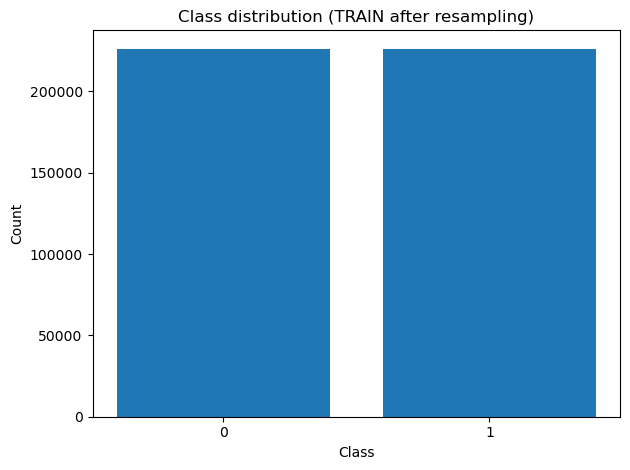

In [14]:
import numpy as np
import matplotlib.pyplot as plt

vals, cnts = np.unique(y_train_bal, return_counts=True)
plt.figure()
plt.title("Class distribution (TRAIN after resampling)")
plt.bar([str(v) for v in vals], cnts)
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Sensitivity (Recall for default=1): 0.6830
ROC AUC: 0.7065

Confusion Matrix (rows=true, cols=pred):
 [[35340 21198]
 [ 1574  3391]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9574    0.6251    0.7563     56538
           1     0.1379    0.6830    0.2295      4965

    accuracy                         0.6297     61503
   macro avg     0.5476    0.6540    0.4929     61503
weighted avg     0.8912    0.6297    0.7138     61503



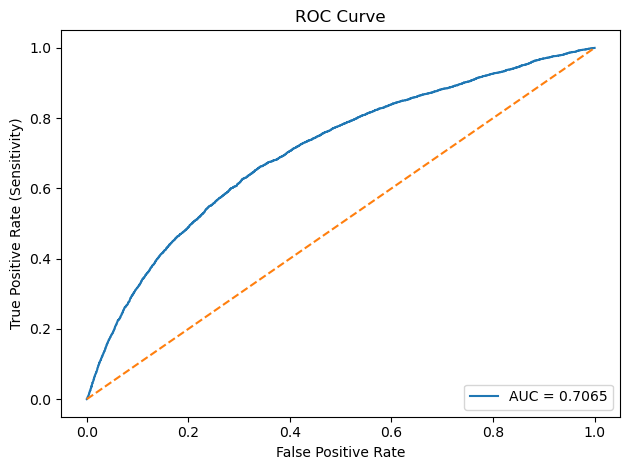

In [12]:

# === 8) Evaluation: Sensitivity & ROC AUC ===
y_prob = mlp.predict_proba(X_test_s)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

sensitivity = recall_score(y_test, y_pred, pos_label=1)  # Sensitivity for default=1
auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
report = classification_report(y_test, y_pred, digits=4)

print(f"Sensitivity (Recall for default=1): {sensitivity:.4f}")
print(f"ROC AUC: {auc:.4f}")
print('\nConfusion Matrix (rows=true, cols=pred):\n', cm)
print('\nClassification Report:\n', report)

# ROC curve
fpr, tpr, thr = roc_curve(y_test, y_prob)
plt.figure()
plt.title("ROC Curve")
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [13]:

# === 9) threshold tuning to boost Sensitivity ===
best_t = 0.5
best_rec = 0.0
for t in np.linspace(0.1, 0.9, 17):
    yp = (y_prob >= t).astype(int)
    rec = recall_score(y_test, yp, pos_label=1)
    if rec > best_rec:
        best_rec, best_t = rec, t

print(f"Best threshold by recall sweep: t={best_t:.2f} with Sensitivity={best_rec:.4f}")


Best threshold by recall sweep: t=0.10 with Sensitivity=0.9061
